In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, confusion_matrix, roc_curve, RocCurveDisplay

import seaborn as sns

In [2]:
chunks = pd.read_csv("data/Family1.csv", chunksize=300000)
dfs = pd.concat(chunks)
dfs = dfs.drop(columns='Unnamed: 0')

In [4]:
dfs.columns

Index(['MI_dir_L5_weight', 'MI_dir_L5_mean', 'MI_dir_L5_variance',
       'MI_dir_L3_weight', 'MI_dir_L3_mean', 'MI_dir_L3_variance',
       'MI_dir_L1_weight', 'MI_dir_L1_mean', 'MI_dir_L1_variance',
       'MI_dir_L0.1_weight',
       ...
       'HpHp_L0.1_pcc', 'HpHp_L0.01_weight', 'HpHp_L0.01_mean',
       'HpHp_L0.01_std', 'HpHp_L0.01_magnitude', 'HpHp_L0.01_radius',
       'HpHp_L0.01_covariance', 'HpHp_L0.01_pcc', 'Threat_Binary', 'Threat'],
      dtype='object', length=117)

In [5]:
X = dfs.drop(columns=["Threat_Binary"])
y = dfs["Threat_Binary"]
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.15, random_state=42)

X_test, X_val, y_test, y_val =  train_test_split(X_test_val, y_test_val, test_size=0.50, random_state=42)

In [6]:
# normalize X_train and X_test
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

df_X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns) #.drop(columns='Unnamed: 0')
df_X_train_scaled["Threat"] = (df_X_train_scaled["Threat"]*10).astype(int)


In [7]:
# undersample malicious traffic
df_y_train = pd.DataFrame(y_train).reset_index().drop(columns="index")
df_X = pd.concat([df_X_train_scaled, df_y_train], axis=1)
n_benign = len(X_train[X_train["Threat"]==0])
n_total_malicious = len(X_train) - n_benign

df_undersampled = []

for attack in range(1,11):
    df_curr = df_X[df_X["Threat"]==attack]
    target_sample = round(n_benign * len(df_curr) / n_total_malicious)
    df_undersampled.append(df_curr.sample(n = target_sample, random_state=40))
    
df_undersampled.append(df_X[df_X["Threat"]==0])

df_X_train_all = pd.concat(df_undersampled, ignore_index=True) 
df_X_train = df_X_train_all.drop(columns="Threat")

In [8]:
df_X_train.columns

Index(['MI_dir_L5_weight', 'MI_dir_L5_mean', 'MI_dir_L5_variance',
       'MI_dir_L3_weight', 'MI_dir_L3_mean', 'MI_dir_L3_variance',
       'MI_dir_L1_weight', 'MI_dir_L1_mean', 'MI_dir_L1_variance',
       'MI_dir_L0.1_weight',
       ...
       'HpHp_L0.1_covariance', 'HpHp_L0.1_pcc', 'HpHp_L0.01_weight',
       'HpHp_L0.01_mean', 'HpHp_L0.01_std', 'HpHp_L0.01_magnitude',
       'HpHp_L0.01_radius', 'HpHp_L0.01_covariance', 'HpHp_L0.01_pcc',
       'Threat_Binary'],
      dtype='object', length=116)

In [9]:
df_plot = df_X_train_all['Threat'].value_counts().sort_index().reset_index()

In [10]:
df_plot

,Threat,count
0,0,42031
1,1,2594
2,2,1258
3,3,1292
4,4,4002
5,5,4597
6,6,4439
7,7,4675
8,8,5316
9,9,10296


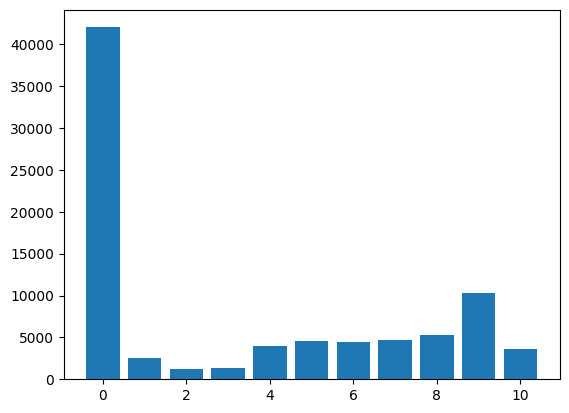

In [11]:
plt.bar(df_plot["Threat"], df_plot["count"])
plt.show()

# Feature selection

In [12]:
from sklearn.linear_model import Lasso

In [13]:
X = df_X_train.drop(columns="Threat_Binary")
y = df_X_train["Threat_Binary"]

In [14]:
model = Lasso(alpha = 0.02)
model.fit(X, y)

selected_indices = np.where(model.coef_ != 0)[0]
selected_features = X.iloc[:,selected_indices]

In [15]:
model.coef_

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  5.46389864e-01,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  2.20122256e-01,
        0.00000000e+00, -

In [16]:
df_X_train.columns[selected_indices]

Index(['MI_dir_L0.1_weight', 'HH_L0.1_weight', 'HH_L0.01_weight',
       'HH_jit_L0.01_weight', 'HH_jit_L0.01_mean'],
      dtype='object')

In [17]:
selected_indices

array([ 9, 51, 58, 77, 78], dtype=int64)

In [18]:
np.round(model.coef_[selected_indices],3)

array([0.546, 0.22 , 0.218, 0.   , 0.606])

In [19]:
X.iloc[:,selected_indices]

,MI_dir_L0.1_weight,HH_L0.1_weight,HH_L0.01_weight,HH_jit_L0.01_weight,HH_jit_L0.01_mean
0,0.827682,0.826612,0.766062,0.766062,1.789501e-05
1,0.964166,0.964088,0.669858,0.669858,2.292073e-05
2,0.986507,0.986338,0.627457,0.627457,2.540804e-05
3,0.318875,0.318630,0.072300,0.072300,3.204715e-04
4,0.937607,0.937143,0.916729,0.916729,1.281997e-05
...,...,...,...,...,...
84057,0.000407,0.000168,0.000246,0.000246,8.297931e-09
84058,0.000428,0.000009,0.000078,0.000078,2.111978e-08
84059,0.000469,0.000009,0.000078,0.000078,1.970947e-08
84060,0.000563,0.000096,0.000233,0.000233,3.499831e-09


In [20]:
df_X_train['Threat_Binary'].shape

(84062,)

# Scikit-learn Logistic Regression

In [21]:
from sklearn.linear_model import LogisticRegression

In [22]:
X_train_scaled.shape

(865553, 116)

In [23]:
X_test_scaled.shape

(76372, 116)

In [24]:
# train the model
X = df_X_train.iloc[:,selected_indices]

log_reg = LogisticRegression(random_state=0, max_iter=1000).fit(X, y)
test_data = pd.DataFrame(X_test_scaled, columns = X_test.columns).loc[:,list(X.columns)]
y_pred_prob = log_reg.predict_proba(test_data)

# calculate loss
logloss = log_loss(y_test, y_pred_prob)
print(round(logloss,3))

0.013


In [25]:
df_X_train.iloc[:,selected_indices].head(3)

,MI_dir_L0.1_weight,HH_L0.1_weight,HH_L0.01_weight,HH_jit_L0.01_weight,HH_jit_L0.01_mean
0,0.827682,0.826612,0.766062,0.766062,0.000018
1,0.964166,0.964088,0.669858,0.669858,0.000023
2,0.986507,0.986338,0.627457,0.627457,0.000025


In [26]:
pd.DataFrame(X_test_scaled, columns = X_test.columns).loc[:,list(X.columns)].head(3)

,MI_dir_L0.1_weight,HH_L0.1_weight,HH_L0.01_weight,HH_jit_L0.01_weight,HH_jit_L0.01_mean
0,0.000000,0.000000,0.0000,0.0000,0.998842
1,0.098258,0.000000,0.0000,0.0000,0.998842
2,0.813086,0.527935,0.8963,0.8963,0.000003


In [27]:
y_pred = log_reg.predict(test_data)
confusion_matrix(y_test, y_pred)

array([[ 3808,    11],
       [  284, 72269]], dtype=int64)

In [28]:
acc = log_reg.score(test_data, y_test)
print(f"Accuracy:{round(acc,4)}")

Accuracy:0.9961


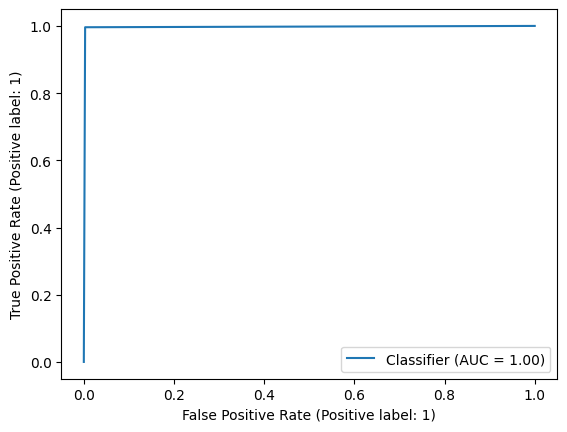

In [29]:
# roc curve
# fpr, tpr, threshold = roc_curve(y_test, y_pred)

RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()

# Logistic Regression

In [30]:
from tensorflow import keras

In [31]:
tf.random.set_seed(1)
np.random.seed(1)

In [32]:
df_X_train.columns[selected_indices]

Index(['MI_dir_L0.1_weight', 'HH_L0.1_weight', 'HH_L0.01_weight',
       'HH_jit_L0.01_weight', 'HH_jit_L0.01_mean'],
      dtype='object')

In [33]:
# convert data to tensor
## training data
numpy_array = df_X_train.iloc[:,selected_indices].to_numpy()
x_train = tf.convert_to_tensor(numpy_array, dtype=tf.float32)

labels = df_X_train["Threat_Binary"].to_numpy()
y_train = tf.convert_to_tensor(labels, dtype=tf.float32)  # Assuming integer labels

## testing data
x_test_np = pd.DataFrame(X_test_scaled, columns = X_test.columns).loc[:,list(df_X_train.columns[selected_indices])].to_numpy()
x_test = tf.convert_to_tensor(x_test_np, dtype=tf.float32)

labels_test = y_test.to_numpy()
y_test = tf.convert_to_tensor(labels_test, dtype=tf.float32)

## validation data
x_val_np = pd.DataFrame(X_val_scaled, columns = X_test.columns).loc[:,list(df_X_train.columns[selected_indices])].to_numpy()
x_val = tf.convert_to_tensor(x_val_np, dtype=tf.float32)

labels_val = y_val.to_numpy()
y_val = tf.convert_to_tensor(labels_val, dtype=tf.float32)

In [39]:
# Define a callback to track loss during training
class LossCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f'Epoch {epoch+1}/{self.params["epochs"]}, Loss: {logs["loss"]:.4f}')

# Build the Logistic Regression Model
model = keras.Sequential([
    keras.layers.Dense(units=1, input_shape=(5,), activation='sigmoid')
])

# Compile the Model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the Model
history = model.fit(x_train, y_train, epochs=40, batch_size=32, verbose=0, 
                    callbacks=[LossCallback()],
                    validation_data=(x_val, y_val))

# Evaluate the Model
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Epoch 1/40, Loss: 0.4194
Epoch 2/40, Loss: 0.1689
Epoch 3/40, Loss: 0.0835
Epoch 4/40, Loss: 0.0487
Epoch 5/40, Loss: 0.0340
Epoch 6/40, Loss: 0.0276
Epoch 7/40, Loss: 0.0244
Epoch 8/40, Loss: 0.0224
Epoch 9/40, Loss: 0.0210
Epoch 10/40, Loss: 0.0199
Epoch 11/40, Loss: 0.0190
Epoch 12/40, Loss: 0.0182
Epoch 13/40, Loss: 0.0175
Epoch 14/40, Loss: 0.0169
Epoch 15/40, Loss: 0.0164
Epoch 16/40, Loss: 0.0158
Epoch 17/40, Loss: 0.0154
Epoch 18/40, Loss: 0.0149
Epoch 19/40, Loss: 0.0145
Epoch 20/40, Loss: 0.0142
Epoch 21/40, Loss: 0.0138
Epoch 22/40, Loss: 0.0135
Epoch 23/40, Loss: 0.0132
Epoch 24/40, Loss: 0.0130
Epoch 25/40, Loss: 0.0127
Epoch 26/40, Loss: 0.0125
Epoch 27/40, Loss: 0.0123
Epoch 28/40, Loss: 0.0121
Epoch 29/40, Loss: 0.0119
Epoch 30/40, Loss: 0.0117
Epoch 31/40, Loss: 0.0116
Epoch 32/40, Loss: 0.0114
Epoch 33/40, Loss: 0.0113
Epoch 34/40, Loss: 0.0111
Epoch 35/40, Loss: 0.0110
Epoch 36/40, Loss: 0.0109
Epoch 37/40, Loss: 0.0108
Epoch 38/40, Loss: 0.0107
Epoch 39/40, Loss: 0.

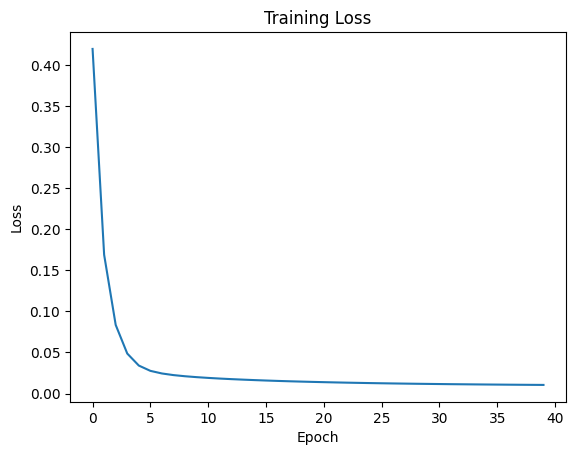

In [40]:
# Get the loss values from the training history
training_loss = history.history['loss']

# Plot the loss graph
plt.plot(training_loss)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

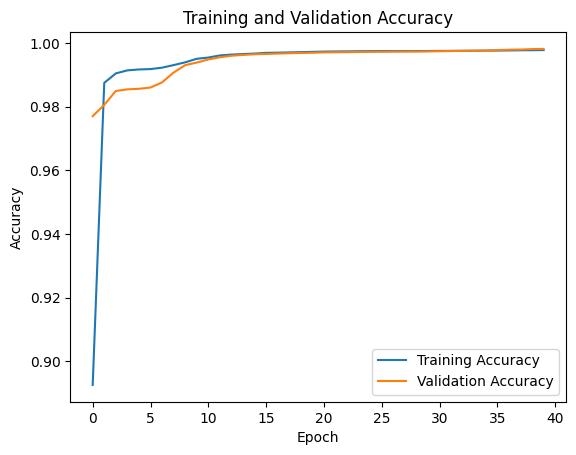

In [41]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [42]:
y_pred = model.predict(x_test)

2387/2387 [==============================] - 1s 528us/step


In [43]:
from sklearn.metrics import classification_report
print(classification_report(y_test, np.round(y_pred)))

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98      3819
         1.0       1.00      1.00      1.00     72553

    accuracy                           1.00     76372
   macro avg       0.98      1.00      0.99     76372
weighted avg       1.00      1.00      1.00     76372



In [44]:
cm = confusion_matrix(y_test, np.round(y_pred))
cm

array([[ 3808,    11],
       [  141, 72412]], dtype=int64)

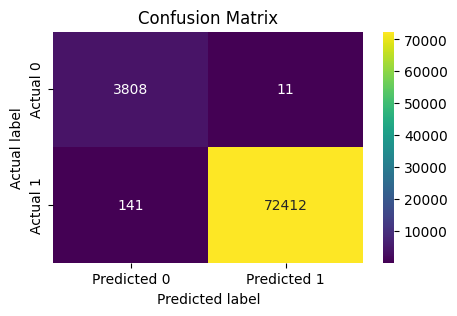

In [47]:
# create heat map
plt.figure(figsize=(5,3))  # Set the figure size
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', 
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.title('Confusion Matrix')
plt.show()

# Data for UMAP

In [63]:
import csv

In [64]:
# undersample
target_sample = 500000
df_sample = dfs.sample(n = target_sample, random_state=40)

In [65]:
# transform the dataset
df_X_sample = df_sample.drop(columns='Threat_Binary')
X_sampled = scaler.transform(df_X_sample)
df_X_sample_scaled = pd.DataFrame(X_sampled, columns=df_X_sample.columns)

In [66]:
df_X_sample_scaled.head()

,MI_dir_L5_weight,MI_dir_L5_mean,MI_dir_L5_variance,MI_dir_L3_weight,MI_dir_L3_mean,MI_dir_L3_variance,MI_dir_L1_weight,MI_dir_L1_mean,MI_dir_L1_variance,MI_dir_L0.1_weight,...,HpHp_L0.1_covariance,HpHp_L0.1_pcc,HpHp_L0.01_weight,HpHp_L0.01_mean,HpHp_L0.01_std,HpHp_L0.01_magnitude,HpHp_L0.01_radius,HpHp_L0.01_covariance,HpHp_L0.01_pcc,Threat
0,0.381282,1.701141e-02,0.000007,0.515522,1.787152e-02,0.000007,0.801206,2.298252e-02,0.000009,0.965924,...,0.067044,0.361561,0.000030,1.648999e-02,4.682399e-09,2.894939e-02,1.897275e-18,0.007392,0.2612,0.1
1,0.500628,3.154982e-01,0.349779,0.562530,3.487084e-01,0.348001,0.726448,4.997527e-01,0.332712,0.819128,...,0.067044,0.361561,0.000000,5.818610e-01,0.000000e+00,4.054946e-01,0.000000e+00,0.007392,0.2612,0.9
2,0.220191,5.089286e-01,0.177819,0.293661,4.645467e-01,0.271492,0.478851,4.949582e-01,0.334677,0.627160,...,0.067044,0.361561,0.900229,5.818610e-01,2.247551e-07,4.054946e-01,4.371321e-15,0.007392,0.2612,1.0
3,0.000000,8.326673e-17,0.000000,0.000000,9.714451e-17,0.000000,0.000000,1.387779e-17,0.000000,0.000000,...,0.067044,0.361561,0.000000,2.775558e-17,0.000000e+00,2.081668e-17,0.000000e+00,0.007392,0.2612,0.4
4,0.317700,5.184515e-01,0.191325,0.410079,4.921179e-01,0.265977,0.629865,5.666436e-01,0.319487,0.792445,...,0.067044,0.361561,0.000000,5.959953e-01,0.000000e+00,4.153447e-01,0.000000e+00,0.007392,0.2612,0.6


In [67]:
# extract features from data
cols = list(df_X_train.columns[selected_indices])
cols_label = list(df_X_train.columns[selected_indices]) + ['Threat_Binary']
df_features = pd.concat([df_X_sample_scaled.loc[:,cols], df_sample['Threat_Binary'].reset_index()], axis=1).drop(columns='index')

In [68]:
df_features.head(5)

,MI_dir_L0.1_weight,HH_L0.1_weight,HH_L0.01_weight,HH_jit_L0.01_weight,HH_jit_L0.01_mean,Threat_Binary
0,0.965924,0.966000,0.741412,0.741412,0.000019,1
1,0.819128,0.535889,0.753909,0.753909,0.000008,1
2,0.627160,0.355208,0.509004,0.509004,0.000012,1
3,0.000000,0.000000,0.000000,0.000000,0.998842,1
4,0.792445,0.522032,0.713028,0.713028,0.000010,1


In [69]:
# find distribution
df_features['Threat_Binary'].value_counts()

Threat_Binary
1    475792
0     24208
Name: count, dtype: int64

In [70]:
combined_array = np.round(df_features.to_numpy(),3)

# Define column names
col_names = ['MI_dir_L0.1_weight', 'HH_L0.1_weight', 'HH_L0.01_weight', 'HH_jit_L0.01_weight', 'HH_jit_L0.01_mean', 'labels']

In [71]:
combined_array.shape

(500000, 6)

In [72]:
file_path = 'data/features_meta.tsv'

# Write the combined NumPy array to the TSV file
with open(file_path, 'w', newline='') as file:

    writer = csv.writer(file, delimiter='\t')
    writer.writerow(col_names)
    
    for row in combined_array:
        writer.writerow(row)  # Write the row string followed by a newline character

In [73]:
file_path = 'data/features_data.tsv'

# Write the combined NumPy array to the TSV file
with open(file_path, 'w', newline='') as file:

    writer = csv.writer(file, delimiter='\t')
    for row in combined_array:
        writer.writerow(row)  # Write the row string followed by a newline character